In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.utils import shuffle
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, roc_auc_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [2]:
# загружаем датасет
try:
    data = pd.read_csv('/datasets/Churn.csv')
except:
    data = pd.read_csv('https://code.s3.yandex.net/datasets/Churn.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [3]:
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


In [4]:
data['Exited'].mean()  # доля ушедших клиентов банка

0.2037

Подготовка признаков для обучения моделей. Разбиение данных на выборки

In [5]:
# удалим признаки, которые незначимы для обучения, то есть не влияют на целевой признак
data = data.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
# заполним пропуски в столбце "Tenure" (сколько лет человек является клиентом банка) медианным значением 
data['Tenure'] = data['Tenure'].fillna(data['Tenure'].median())
# закодируем категориальные признаки методом прямого кодирования (One-Hot Encoding)
data = pd.get_dummies(data, drop_first=True, columns=['Geography', 'Gender'])
# отделим целевой признак от остальных признаков
features = data.drop('Exited', axis=1)
target = data['Exited']
features.info()  # проверим, что выборка разделена корректно

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        10000 non-null  int64  
 1   Age                10000 non-null  int64  
 2   Tenure             10000 non-null  float64
 3   Balance            10000 non-null  float64
 4   NumOfProducts      10000 non-null  int64  
 5   HasCrCard          10000 non-null  int64  
 6   IsActiveMember     10000 non-null  int64  
 7   EstimatedSalary    10000 non-null  float64
 8   Geography_Germany  10000 non-null  bool   
 9   Geography_Spain    10000 non-null  bool   
 10  Gender_Male        10000 non-null  bool   
dtypes: bool(3), float64(3), int64(5)
memory usage: 654.4 KB


In [6]:
target.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

In [7]:
# разделим данные на обучающую, валидационную и тестовую выборки
features_train, features_val_test, target_train, target_val_test = train_test_split(features, target, test_size=0.4, random_state=42, stratify=target)
features_valid, features_test, target_valid, target_test = train_test_split(features_val_test, target_val_test, test_size=0.5, random_state=42, stratify=target_val_test)
# проверим размеры выборок, а также то, что изначальное распределение классов сохранилось
display(features_train.shape, target_train.shape)
display(features_valid.shape, target_valid.shape)
display(features_test.shape, target_test.shape)
display(target_train.mean())

(6000, 11)

(6000,)

(2000, 11)

(2000,)

(2000, 11)

(2000,)

0.20366666666666666

In [8]:
# стандартизируем численные признаки
pd.options.mode.chained_assignment = None

scaler = StandardScaler()
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
scaler.fit(features_train[numeric])
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
features_train.head() # проверяем, что все изменения произведены корректно

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
6851,-1.283897,0.008566,1.449637,0.330105,0.783996,1,0,-0.084061,True,False,False
7026,0.271537,-1.139895,-0.001572,-1.220584,0.783996,0,1,0.264021,False,False,False
5705,-0.236571,0.104271,-0.001572,1.692794,0.783996,1,1,0.515344,True,False,True
9058,-1.874962,0.869911,-0.001572,1.032566,-0.919109,1,1,0.303842,False,True,False
9415,1.215167,0.391386,-1.089979,0.851257,0.783996,0,0,-1.400817,True,False,False


In [9]:
data['Exited'].value_counts()  # оценим сбалансированность данных

Exited
0    7963
1    2037
Name: count, dtype: int64

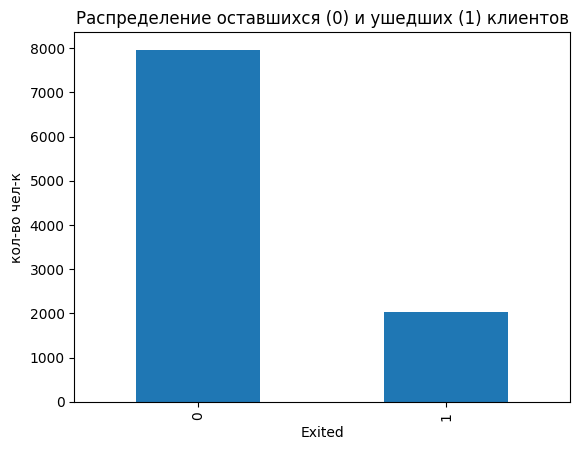

In [10]:
data['Exited'].value_counts().plot(kind='bar')
plt.title("Распределение оставшихся (0) и ушедших (1) клиентов")
plt.ylabel("кол-во чел-к")
plt.show()

In [11]:
data['Exited'].mean()  # доля ушедших клиентов банка

0.2037

Дерево решиний

In [12]:
best_model_tree = None
best_result_tree = 0
best_depth_tree = 0
for depth in range(1, 10):
    # инициализация модели с заданной максимальной глубиной дерева
    model = DecisionTreeClassifier(random_state=42, max_depth=depth)
    model.fit(features_train, target_train) # обучение модели
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid) # качество модели на валидационной выборке
    if result > best_result_tree:
        best_model_tree = model
        best_result_tree = result
        best_depth_tree = depth

In [13]:
display(best_result_tree) # лучший результат f1-score модели
display(best_depth_tree) # глубина дерева у лучшей модели

0.5918367346938777

8

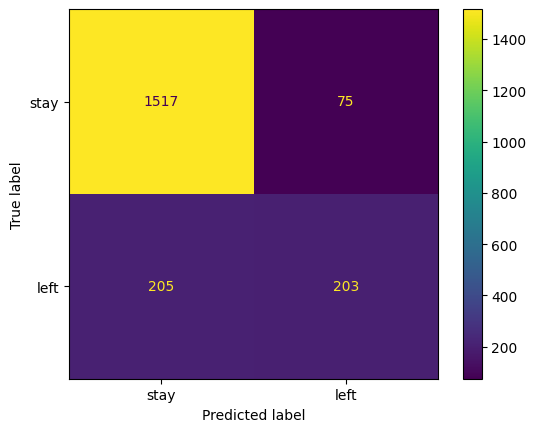

In [14]:
# матрица ошибок для дерева решений
cm = confusion_matrix(target_valid, best_model_tree.predict(features_valid))
disp = ConfusionMatrixDisplay(cm, display_labels=['stay', 'left']).plot()

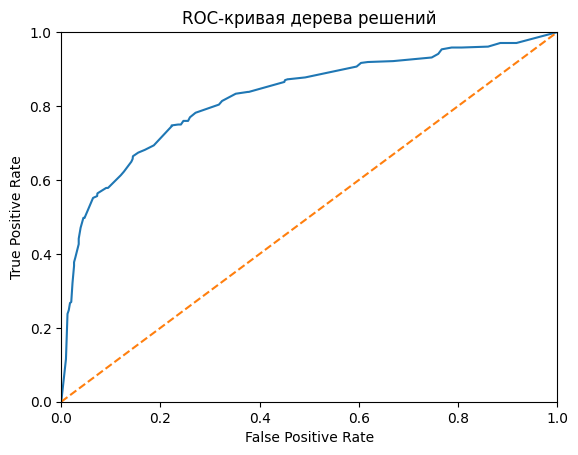

In [15]:
# ROC-кривая для дерева решений
probabilities_valid = best_model_tree.predict_proba(features_valid)

fpr_tree, tpr_tree, thresholds_tree = roc_curve(target_valid, probabilities_valid[:, 1]) 

plt.figure()
plt.plot(fpr_tree, tpr_tree)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая дерева решений")
plt.show()

In [16]:
roc_auc_score(target_valid, probabilities_valid[:, 1])

0.8245162700758696

Случайный лес

In [17]:
# объединенная выборка из train и validation
features_train_val = pd.concat([features_train, features_valid], ignore_index=True)
target_train_val = pd.concat([target_train, target_valid], ignore_index=True)

In [18]:
features_train_val.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        8000 non-null   float64
 1   Age                8000 non-null   float64
 2   Tenure             8000 non-null   float64
 3   Balance            8000 non-null   float64
 4   NumOfProducts      8000 non-null   float64
 5   HasCrCard          8000 non-null   int64  
 6   IsActiveMember     8000 non-null   int64  
 7   EstimatedSalary    8000 non-null   float64
 8   Geography_Germany  8000 non-null   bool   
 9   Geography_Spain    8000 non-null   bool   
 10  Gender_Male        8000 non-null   bool   
dtypes: bool(3), float64(6), int64(2)
memory usage: 523.6 KB


In [19]:
features_train_val.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,-1.283897,0.008566,1.449637,0.330105,0.783996,1,0,-0.084061,True,False,False
1,0.271537,-1.139895,-0.001572,-1.220584,0.783996,0,1,0.264021,False,False,False
2,-0.236571,0.104271,-0.001572,1.692794,0.783996,1,1,0.515344,True,False,True
3,-1.874962,0.869911,-0.001572,1.032566,-0.919109,1,1,0.303842,False,True,False
4,1.215167,0.391386,-1.089979,0.851257,0.783996,0,0,-1.400817,True,False,False


In [20]:
%%time

parametrs = { 'n_estimators': range(20, 101, 10),
              'max_depth': range(1, 13) }

model = RandomForestClassifier(random_state=42)
# подбор лучших параметров модели
grid = GridSearchCV(model, parametrs, scoring='f1', verbose=1)
grid.fit(features_train_val, target_train_val)

best_model_forest = grid.best_estimator_
best_parametrs_forest = grid.best_params_
best_result_forest = grid.best_score_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
CPU times: user 3min 56s, sys: 697 ms, total: 3min 57s
Wall time: 3min 57s


In [21]:
display(best_result_forest) # лучший результат f1-score модели
display(best_parametrs_forest) # лучшие параметры модели

0.5787688881402255

{'max_depth': 12, 'n_estimators': 80}

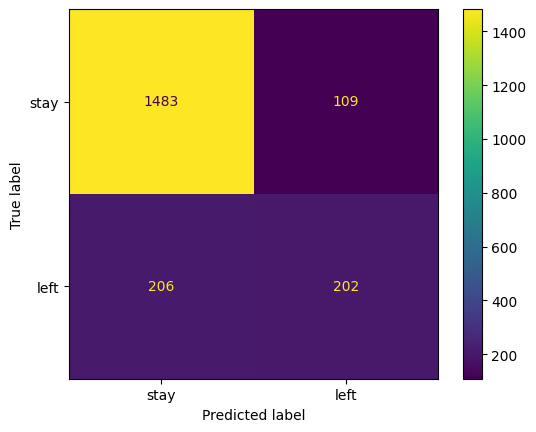

In [22]:
# матрица ошибок для случайного леса
cm = confusion_matrix(target_valid, predicted_valid)
disp = ConfusionMatrixDisplay(cm, display_labels=['stay', 'left']).plot()

Логистическая регрессия

In [23]:
best_model_log_reg = None
best_result_log_reg = 0
best_iter_log_reg = 0
for i in range (1000, 3001, 100):
    # инициализация модели с заданным максимальным количеством итераций
    model = LogisticRegression(random_state=42, solver='liblinear', max_iter=i)
    model.fit(features_train, target_train) # обучение модели
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid) # качество модели на валидационной выборке
    if result > best_result_log_reg:
        best_model_log_reg = model
        best_result_log_reg = result
        best_iter_log_reg = i

In [24]:
display(best_result_log_reg) # лучший результат f1-score модели
display(best_iter_log_reg) # количество интераций

0.32792792792792796

1000

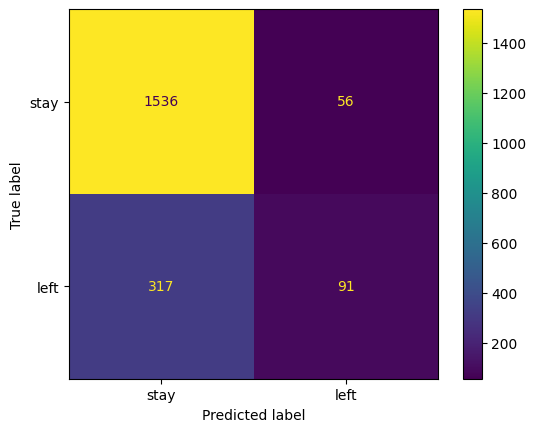

In [25]:
# матрица ошибок для логистической регрессии
cm = confusion_matrix(target_valid, best_model_log_reg.predict(features_valid))
disp = ConfusionMatrixDisplay(cm, display_labels=['stay', 'left']).plot()

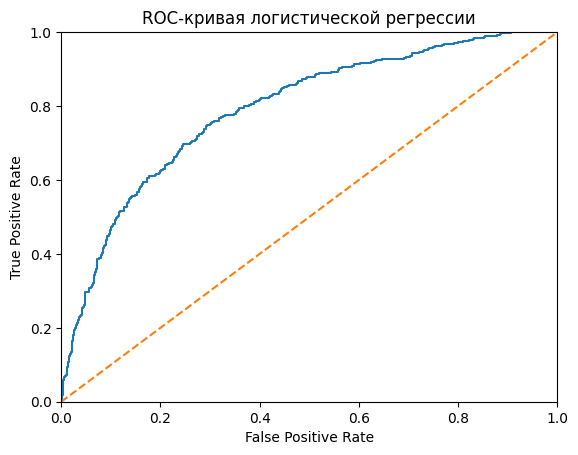

In [26]:
# ROC-кривая для логистической регрессии
probabilities_valid = best_model_log_reg.predict_proba(features_valid)

fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(target_valid, probabilities_valid[:, 1]) 

plt.figure()
plt.plot(fpr_log_reg, tpr_log_reg)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая логистической регрессии")
plt.show()

In [27]:
roc_auc_score(target_valid, probabilities_valid[:, 1])

0.7908014336387822

Борьба с дисбалансом

In [28]:
f1_score_diff_methods = pd.DataFrame(index=['DecisionTree', 'RandomForest', 'LogisticRegression'], 
                                     columns=['Class_weight', 'Upsampling', 'Downsampling'])

Веса классов

Дерево решиний

In [29]:
best_model_tree = None
best_result_tree = 0
best_depth_tree = 0
for depth in range(1, 10):
    # инициализация модели с заданной максимальной глубиной дерева
    model = DecisionTreeClassifier(random_state=42, max_depth=depth, class_weight='balanced')
    model.fit(features_train, target_train) # обучение модели
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid) # качество модели на валидационной выборке
    if result > best_result_tree:
        best_model_tree = model
        best_result_tree = result
        best_depth_tree = depth

In [30]:
display(best_result_tree) # лучший результат f1-score модели
display(best_depth_tree) # глубина дерева у лучшей модели
f1_score_diff_methods.loc['DecisionTree', 'Class_weight'] = best_result_tree

0.5754141238012207

6

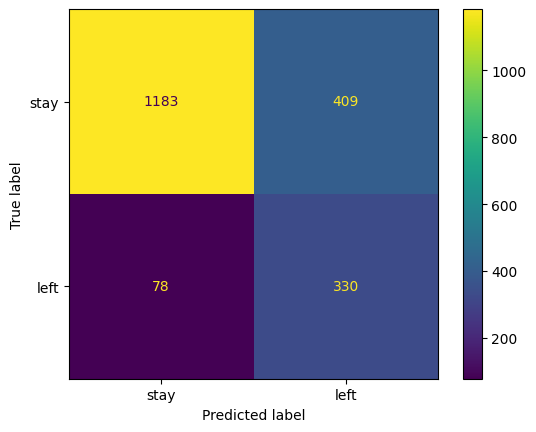

In [31]:
# матрица ошибок для дерева решений
cm = confusion_matrix(target_valid, best_model_tree.predict(features_valid))
disp = ConfusionMatrixDisplay(cm, display_labels=['stay', 'left']).plot()

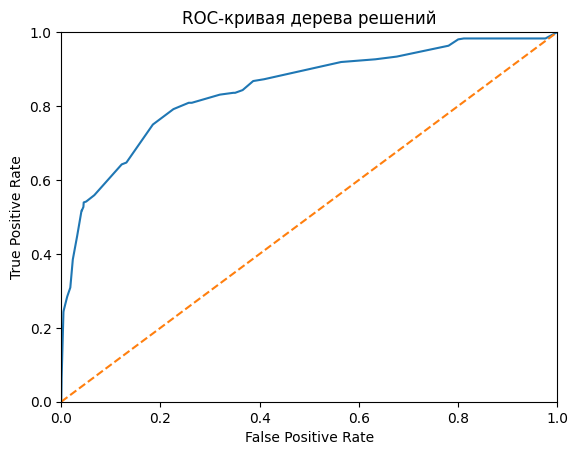

In [32]:
# ROC-кривая для дерева решений
probabilities_valid = best_model_tree.predict_proba(features_valid)

fpr_tree, tpr_tree, thresholds_tree = roc_curve(target_valid, probabilities_valid[:, 1]) 

plt.figure()
plt.plot(fpr_tree, tpr_tree)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая дерева решений")
plt.show()

In [33]:
roc_auc_score(target_valid, probabilities_valid[:, 1])

0.8457929968469801

Случайный лес

In [34]:
%%time

parametrs = { 'n_estimators': range(40, 101, 10),
              'max_depth': range(1, 13) }

model = RandomForestClassifier(random_state=42, class_weight='balanced')
# подбор лучших параметров модели
grid = GridSearchCV(model, parametrs, scoring='f1', verbose=1)
grid.fit(features_train_val, target_train_val)

best_model_forest = grid.best_estimator_
best_parametrs_forest = grid.best_params_
best_result_forest = grid.best_score_

Fitting 5 folds for each of 84 candidates, totalling 420 fits
CPU times: user 3min 33s, sys: 624 ms, total: 3min 33s
Wall time: 3min 33s


In [35]:
display(best_result_forest) # лучший результат f1-score модели
display(best_parametrs_forest) # лучшие параметры модели
f1_score_diff_methods.loc['RandomForest', 'Class_weight'] = best_result_forest

0.6205088122226959

{'max_depth': 10, 'n_estimators': 90}

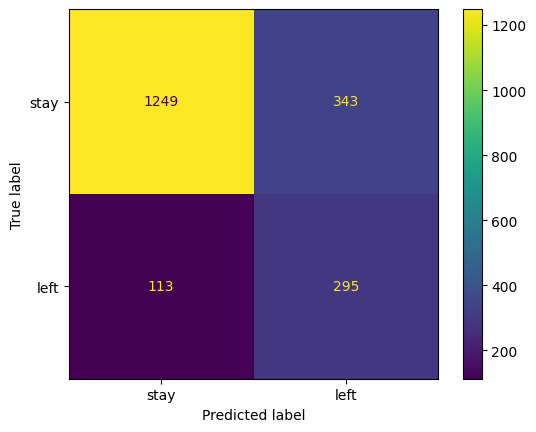

In [36]:
# матрица ошибок для случайного леса
cm = confusion_matrix(target_valid, predicted_valid)
disp = ConfusionMatrixDisplay(cm, display_labels=['stay', 'left']).plot()

Логистическая регрессия

In [37]:
best_model_log_reg = None
best_result_log_reg = 0
best_iter_log_reg = 0
for i in range (1000, 3001, 100):
    # инициализация модели с заданным максимальным количеством итераций
    model = LogisticRegression(random_state=42, solver='liblinear', max_iter=i, class_weight='balanced')
    model.fit(features_train, target_train) # обучение модели
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid) # качество модели на валидационной выборке
    if result > best_result_log_reg:
        best_model_log_reg = model
        best_result_log_reg = result
        best_iter_log_reg = i

In [38]:
display(best_result_log_reg) # лучший результат f1-score модели
display(best_iter_log_reg) # количество интераций
f1_score_diff_methods.loc['LogisticRegression', 'Class_weight'] = best_result_log_reg

0.5196581196581197

1000

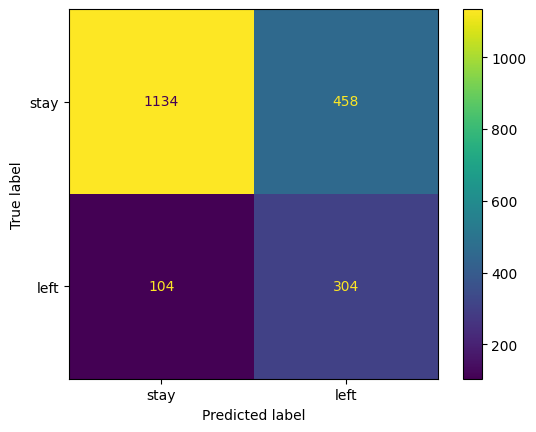

In [39]:
# матрица ошибок для логистической регрессии
cm = confusion_matrix(target_valid, best_model_log_reg.predict(features_valid))
disp = ConfusionMatrixDisplay(cm, display_labels=['stay', 'left']).plot()

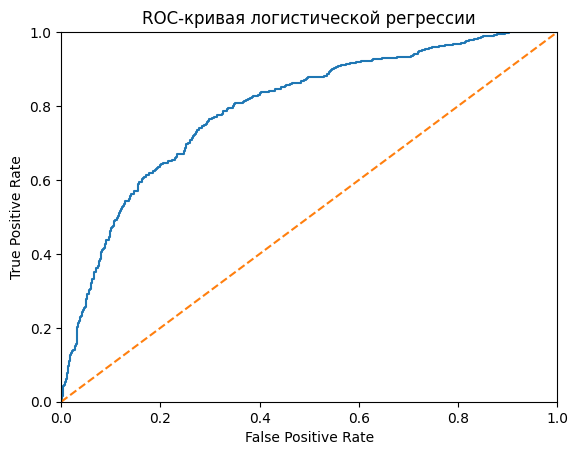

In [40]:
# ROC-кривая для логистической регрессии
probabilities_valid = best_model_log_reg.predict_proba(features_valid)

fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(target_valid, probabilities_valid[:, 1]) 

plt.figure()
plt.plot(fpr_log_reg, tpr_log_reg)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая логистической регрессии")
plt.show()

In [41]:
roc_auc_score(target_valid, probabilities_valid[:, 1])

0.7938174327519953

Увеличение выборки. Upsampling.

In [42]:
# функция для увеличения выборки
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=42)
    
    return features_upsampled, target_upsampled

In [43]:
# подготовим выборки; repeat = 4, т.к нулевого класса примерно в 4 раза больше, чем положительного
features_upsampled_train, target_upsampled_train = upsample(features_train, target_train, 4)

In [44]:
# проверяем, как уравнялись классы
display(target_upsampled_train.value_counts())

Exited
1    4888
0    4778
Name: count, dtype: int64

Дерево решиний

In [45]:
best_model_tree = None
best_result_tree = 0
best_depth_tree = 0
for depth in range(1, 10):
    # инициализация модели с заданной максимальной глубиной дерева
    model = DecisionTreeClassifier(random_state=42, max_depth=depth)
    model.fit(features_upsampled_train, target_upsampled_train) # обучение модели
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid) # качество модели на валидационной выборке
    if result > best_result_tree:
        best_model_tree = model
        best_result_tree = result
        best_depth_tree = depth

In [46]:
display(best_result_tree) # лучший результат f1-score модели
display(best_depth_tree) # глубина дерева у лучшей модели
f1_score_diff_methods.loc['DecisionTree', 'Upsampling'] = best_result_tree

0.5749128919860628

6

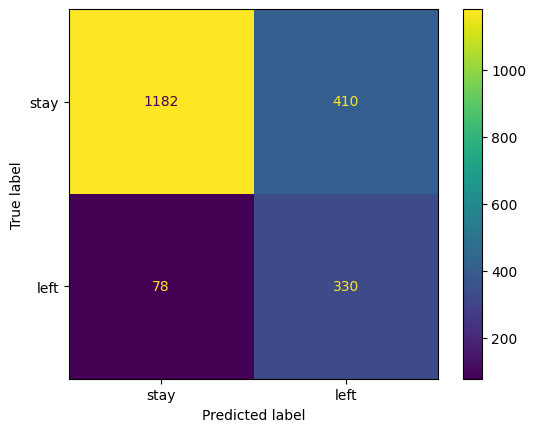

In [47]:
# матрица ошибок для дерева решений
cm = confusion_matrix(target_valid, best_model_tree.predict(features_valid))
disp = ConfusionMatrixDisplay(cm, display_labels=['stay', 'left']).plot()

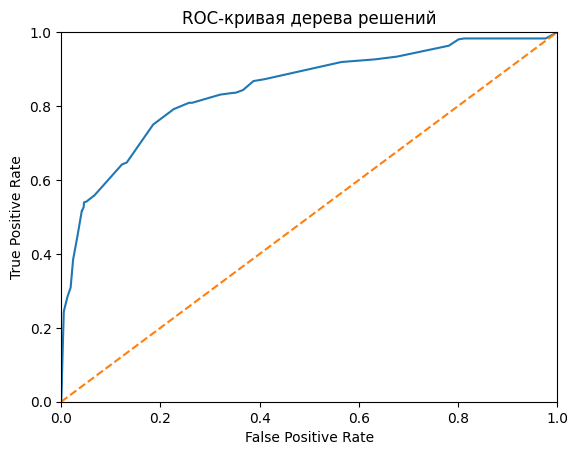

In [48]:
# ROC-кривая для дерева решений
probabilities_valid = best_model_tree.predict_proba(features_valid)

fpr_tree, tpr_tree, thresholds_tree = roc_curve(target_valid, probabilities_valid[:, 1]) 

plt.figure()
plt.plot(fpr_tree, tpr_tree)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая дерева решений")
plt.show()

In [49]:
roc_auc_score(target_valid, probabilities_valid[:, 1])

0.8451871797714059

Случайный лес

In [50]:
%%time

parametrs = { 'n_estimators': range(40, 121, 10),
              'max_depth': range(1, 13) }
imba_pipeline = make_pipeline(SMOTE(random_state=42), 
                              RandomForestClassifier(random_state=42))
# подбор лучших параметров модели
new_params = {'randomforestclassifier__' + key: parametrs[key] for key in parametrs}
grid = GridSearchCV(imba_pipeline, param_grid=new_params, scoring='f1', verbose=1)
grid.fit(features_train_val, target_train_val)


best_model_forest = grid.best_estimator_
best_parametrs_forest = grid.best_params_
best_result_forest = grid.best_score_

Fitting 5 folds for each of 108 candidates, totalling 540 fits
CPU times: user 8min 11s, sys: 953 ms, total: 8min 12s
Wall time: 8min 12s


In [51]:
display(best_result_forest) # лучший результат f1-score модели
display(best_parametrs_forest) # лучшие параметры модели
f1_score_diff_methods.loc['RandomForest', 'Upsampling'] = best_result_forest

0.6122488761964198

{'randomforestclassifier__max_depth': 12,
 'randomforestclassifier__n_estimators': 110}

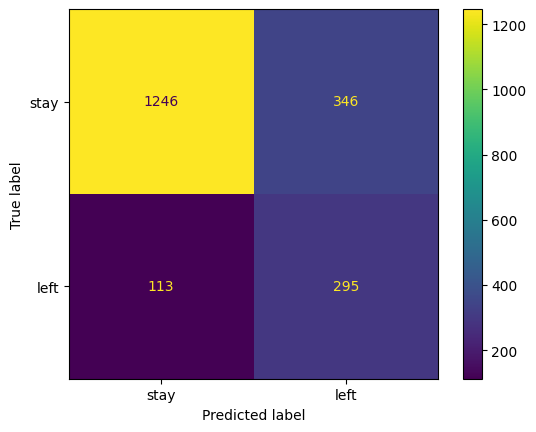

In [52]:
# матрица ошибок для случайного леса
cm = confusion_matrix(target_valid, predicted_valid)
disp = ConfusionMatrixDisplay(cm, display_labels=['stay', 'left']).plot()

Логистическая регрессия

In [53]:
best_model_log_reg = None
best_result_log_reg = 0
best_iter_log_reg = 0
for i in range (1000, 3001, 100):
    # инициализация модели с заданным максимальным количеством итераций
    model = LogisticRegression(random_state=42, solver='liblinear', max_iter=i)
    model.fit(features_upsampled_train, target_upsampled_train) # обучение модели
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid) # качество модели на валидационной выборке
    if result > best_result_log_reg:
        best_model_log_reg = model
        best_result_log_reg = result
        best_iter_log_reg = i

In [54]:
display(best_result_log_reg) # лучший результат f1-score модели
display(best_iter_log_reg) # количество интераций
f1_score_diff_methods.loc['LogisticRegression', 'Upsampling'] = best_result_log_reg

0.5206402695871947

1000

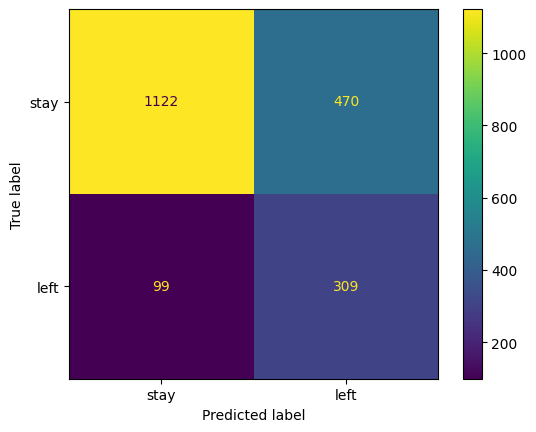

In [55]:
# матрица ошибок для логистической регрессии
cm = confusion_matrix(target_valid, best_model_log_reg.predict(features_valid))
disp = ConfusionMatrixDisplay(cm, display_labels=['stay', 'left']).plot()

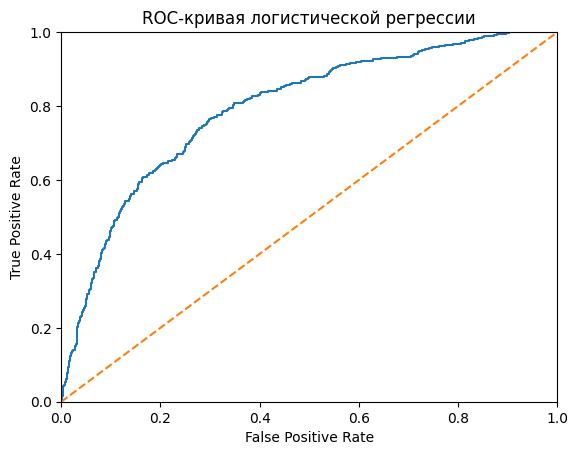

In [56]:
# ROC-кривая для логистической регрессии
probabilities_valid = best_model_log_reg.predict_proba(features_valid)

fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(target_valid, probabilities_valid[:, 1]) 

plt.figure()
plt.plot(fpr_log_reg, tpr_log_reg)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая логистической регрессии")
plt.show()

In [57]:
roc_auc_score(target_valid, probabilities_valid[:, 1])

0.7938420657207607

Уменьшение выборки. Downsampling.

In [58]:
# функция для уменьшение выборки
def downsample(features, target, fraction):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=42)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=42)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=42)
    
    return features_downsampled, target_downsampled

In [59]:
# подготовим выборки; fraction = 0.25, т.к нулевого класса примерно в 4 раза больше, чем положительного
features_downsampled_train, target_downsampled_train = downsample(features_train, target_train, 0.25)

In [60]:
# проверяем, как уравнялись классы
display(target_downsampled_train.value_counts())

Exited
1    1222
0    1194
Name: count, dtype: int64

Дерево решиний

In [61]:
best_model_tree = None
best_result_tree = 0
best_depth_tree = 0
for depth in range(1, 10):
    # инициализация модели с заданной максимальной глубиной дерева
    model = DecisionTreeClassifier(random_state=42, max_depth=depth)
    model.fit(features_downsampled_train, target_downsampled_train) # обучение модели
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid) # качество модели на валидационной выборке
    if result > best_result_tree:
        best_model_tree = model
        best_result_tree = result
        best_depth_tree = depth

In [62]:
display(best_result_tree) # лучший результат f1-score модели
display(best_depth_tree) # глубина дерева у лучшей модели
f1_score_diff_methods.loc['DecisionTree', 'Downsampling'] = best_result_tree

0.5827937095282146

6

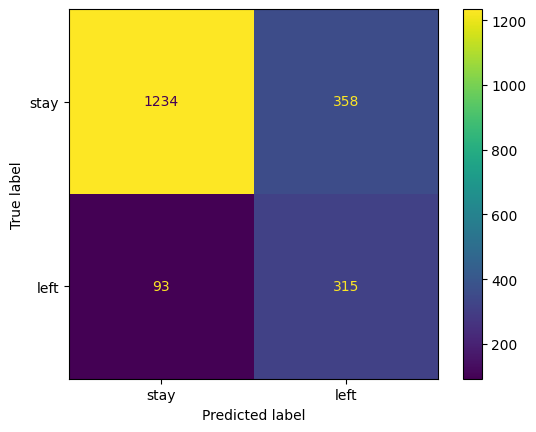

In [63]:
# матрица ошибок для дерева решений
cm = confusion_matrix(target_valid, best_model_tree.predict(features_valid))
disp = ConfusionMatrixDisplay(cm, display_labels=['stay', 'left']).plot()

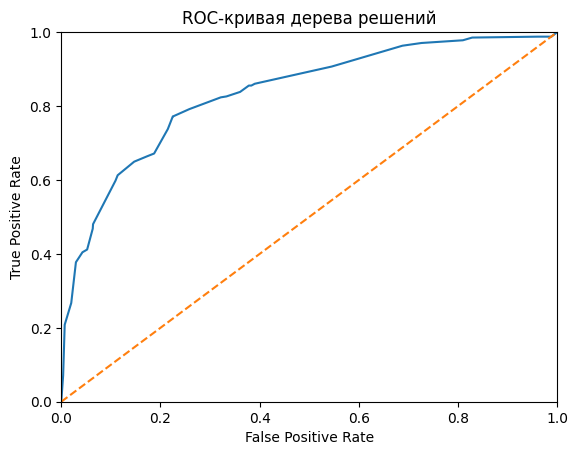

In [64]:
# ROC-кривая для дерева решений
probabilities_valid = best_model_tree.predict_proba(features_valid)

fpr_tree, tpr_tree, thresholds_tree = roc_curve(target_valid, probabilities_valid[:, 1]) 

plt.figure()
plt.plot(fpr_tree, tpr_tree)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая дерева решений")
plt.show()

In [65]:
roc_auc_score(target_valid, probabilities_valid[:, 1])

0.834046919647256

Случайный лес

In [66]:
%%time

parametrs = { 'n_estimators': range(60, 161, 10),
              'max_depth': range(1, 13) }
imba_pipeline = make_pipeline(RandomUnderSampler(random_state=42), 
                              RandomForestClassifier(random_state=42))
# подбор лучших параметров модели
new_params = {'randomforestclassifier__' + key: parametrs[key] for key in parametrs}
grid = GridSearchCV(imba_pipeline, param_grid=new_params, scoring='f1', verbose=1)
grid.fit(features_train_val, target_train_val)


best_model_forest = grid.best_estimator_
best_parametrs_forest = grid.best_params_
best_result_forest = grid.best_score_

Fitting 5 folds for each of 132 candidates, totalling 660 fits
CPU times: user 5min 16s, sys: 1.21 s, total: 5min 17s
Wall time: 5min 17s


In [67]:
display(best_result_forest) # лучший результат f1-score модели
display(best_parametrs_forest) # лучшие параметры модели
f1_score_diff_methods.loc['RandomForest', 'Downsampling'] = best_result_forest

0.5993784589719997

{'randomforestclassifier__max_depth': 9,
 'randomforestclassifier__n_estimators': 140}

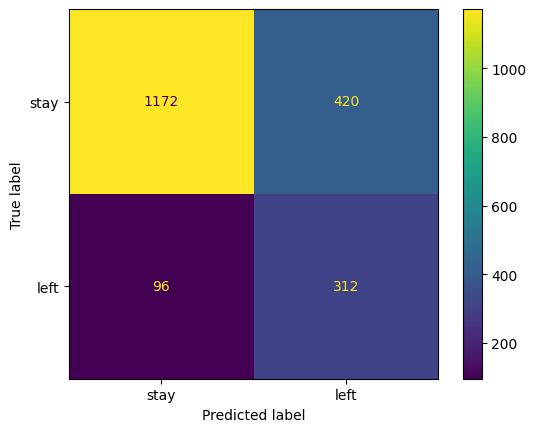

In [68]:
# матрица ошибок для случайного леса
cm = confusion_matrix(target_valid, predicted_valid)
disp = ConfusionMatrixDisplay(cm, display_labels=['stay', 'left']).plot()

Логистическая регрессия

In [69]:
best_model_log_reg = None
best_result_log_reg = 0
best_iter_log_reg = 0
for i in range (1000, 3001, 100):
    # инициализация модели с заданным максимальным количеством итераций
    model = LogisticRegression(random_state=42, solver='liblinear', max_iter=i)
    model.fit(features_downsampled_train, target_downsampled_train) # обучение модели
    predicted_valid = model.predict(features_valid)
    result = f1_score(target_valid, predicted_valid) # качество модели на валидационной выборке
    if result > best_result_log_reg:
        best_model_log_reg = model
        best_result_log_reg = result
        best_iter_log_reg = i

In [70]:
display(best_result_log_reg) # лучший результат f1-score модели
display(best_iter_log_reg) # количество интераций
f1_score_diff_methods.loc['LogisticRegression', 'Downsampling'] = best_result_log_reg

0.5234113712374583

1000

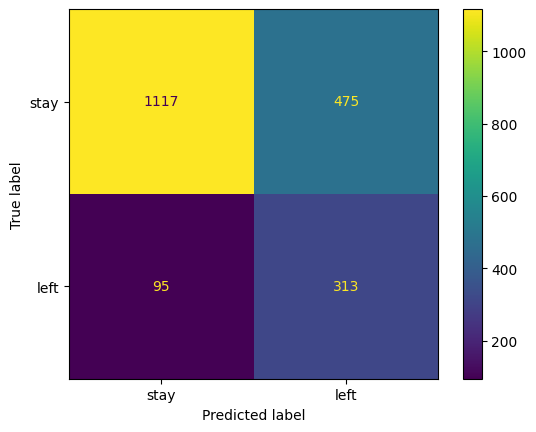

In [71]:
# матрица ошибок для логистической регрессии
cm = confusion_matrix(target_valid, best_model_log_reg.predict(features_valid))
disp = ConfusionMatrixDisplay(cm, display_labels=['stay', 'left']).plot()

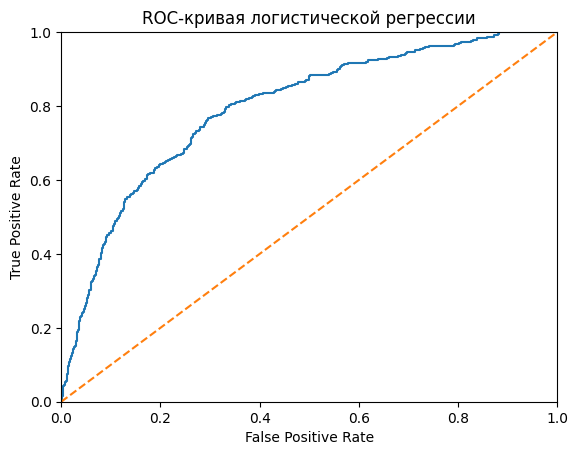

In [72]:
# ROC-кривая для логистической регрессии
probabilities_valid = best_model_log_reg.predict_proba(features_valid)

fpr_log_reg, tpr_log_reg, thresholds_log_reg = roc_curve(target_valid, probabilities_valid[:, 1]) 

plt.figure()
plt.plot(fpr_log_reg, tpr_log_reg)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая логистической регрессии")
plt.show()

In [73]:
roc_auc_score(target_valid, probabilities_valid[:, 1])

0.7940345107892403

In [74]:
# сводная таблица f1-score по всем методам и моделям
f1_score_diff_methods['Class_weight'] = pd.to_numeric(f1_score_diff_methods['Class_weight'])
f1_score_diff_methods['Upsampling'] = pd.to_numeric(f1_score_diff_methods['Upsampling'])
f1_score_diff_methods['Downsampling'] = pd.to_numeric(f1_score_diff_methods['Downsampling'])
f1_score_diff_methods.round(2)

,Class_weight,Upsampling,Downsampling
DecisionTree,0.58,0.57,0.58
RandomForest,0.62,0.61,0.60
LogisticRegression,0.52,0.52,0.52


Тестирование модели

In [75]:
model = RandomForestClassifier(random_state=42, n_estimators=90, max_depth=10, class_weight='balanced')
model.fit(features_train_val, target_train_val) # обучение модели на объединенной выборке из train и validation
predicted_test = model.predict(features_test)
f1_score(target_test, predicted_test)

0.6177884615384616

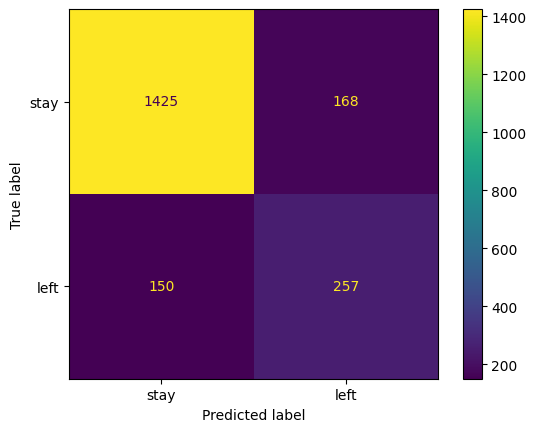

In [76]:
# матрица ошибок
cm = confusion_matrix(target_test, predicted_test)
disp = ConfusionMatrixDisplay(cm, display_labels=['stay', 'left']).plot()

In [77]:
# метрики модели
print(classification_report(target_test, predicted_test, target_names=['stay', 'left']))

              precision    recall  f1-score   support

        stay       0.90      0.89      0.90      1593
        left       0.60      0.63      0.62       407

    accuracy                           0.84      2000
   macro avg       0.75      0.76      0.76      2000
weighted avg       0.84      0.84      0.84      2000



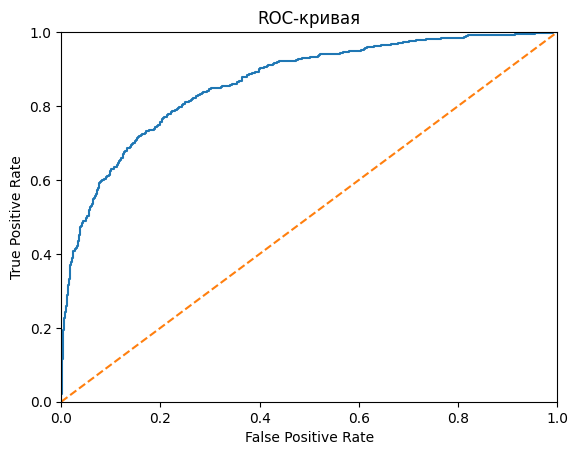

In [78]:
# ROC-кривая модели
probabilities_test = model.predict_proba(features_test)

fpr, tpr, thresholds = roc_curve(target_test, probabilities_test[:, 1]) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0]) 
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate") 
plt.ylabel("True Positive Rate")
plt.title("ROC-кривая")
plt.show()

In [79]:
roc_auc_score(target_test, probabilities_test[:, 1])

0.8628659476117103